In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import *

In [180]:
def stim_gen(i):
    global nf
    stim_vec = np.zeros(nf)
    if i is not None:
        stim_vec[i] = 1
    return stim_vec

class iSITH():
    def __init__(self, tau_min=.1, tau_max=3, buff_max=None, k=50, ntau=20, dt=1, g=0.0):
        super(iSITH, self).__init__()
        self.k = k
        self.tau_min = tau_min
        self.tau_max = tau_max
        if buff_max is None:
            buff_max = 3*tau_max
        self.buff_max = buff_max
        self.ntau = ntau
        self.dt = dt
        self.g = g

        self.c = (tau_max/tau_min)**(1./(ntau-1))-1
        self.tau_star = tau_min*(1+self.c)**np.arange(ntau).astype(float)
        self.s = 1/self.tau_star

class worker():
    def __init__(self, s, a, nf=2):
        self.a = a
        self.s = s
        self.M = np.zeros([nf,nf])
        self.F = np.zeros(nf)
        self.P = np.zeros(nf)
    def update(self, dt, fi_IN: None, f_IN: None, P_smax: float):
        if fi_IN is not None:
            self.F += (-self.s*self.F)*dt + f_IN
            P_IN = np.dot(self.M, f_IN)
            self.P += (self.s*self.P)*dt + P_IN - P_smax
            for past_stim in np.flatnonzero(self.F):
                if past_stim != fi_IN:
                    self.M[fi_IN,past_stim] = self.a*self.M[fi_IN,past_stim]+(1-self.a)*self.F[past_stim]
        else:
            self.F += (-self.s*self.F)*dt
            self.P += (self.s*self.P)*dt  - P_smax
        return (self.F, self.P)

In [181]:
# no. of stimuli x2 for not-stimuli as well
nf = 2#*2
# variables
dt = 0.01
#A = np.arange(0,1,0.2)
a = 0.2
e = 0.0000005

In [182]:
S = iSITH(tau_min=0.1,tau_max=3,ntau=20).s
#stim presentation
t_x1 = 1
t_y = 2
t_x2 = 7
#time steps
t_max = 9#t_x2+(t_y-t_x1)+4
T = np.arange(0,t_max, dt)

In [184]:
workers = []
predictions = np.zeros([len(S), nf])
for s in S:
    workers.append(worker(s, a))
    
P_smax = 0
F_xtrack = np.zeros(len(S))
P_ytrack = np.zeros(len(S))

f = [[0,t_x1],[1,t_y],[0,t_x2],[0,t_max+0.1]]
(stim, stim_t) = f.pop(0)

for t in T:
    if stim_t == t:
        fi_IN = stim
        f_IN = stim_gen(fi_IN)
        (stim, stim_t) = f.pop(0)
    else: 
        fi_IN = None
        f_IN = None
    P_sum = np.zeros(nf)
    F = np.zeros([len(S),nf])
    P = np.zeros([len(S),nf])
    for i in range(len(S)):
        (F[i], P[i]) = workers[i].update(dt=dt,fi_IN=fi_IN,f_IN=f_IN,P_smax=P_smax)        
    P_smax = workers[0].P
    P_sum = P_y.sum()
    #if (t>t_x2)&(P_sum < e):
        #print("Not Y predicted at %s" %(t))
    F_xtrack = np.row_stack((F_xtrack, F[:,0]))
    P_ytrack = np.row_stack((P_ytrack, P[:,1]))
F_xtrack = F_xtrack[1:,:]
P_ytrack = P_ytrack[1:,:]

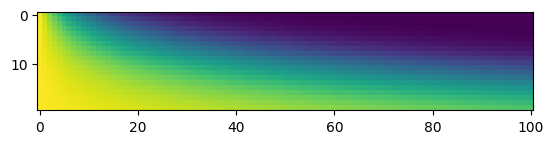

In [185]:
plt.imshow(F_xtrack[100:201,:].T)

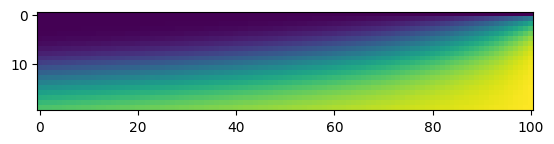

In [186]:
plt.imshow(P_ytrack[700:801,:].T)

In [188]:
P_ytrack[800,:]

array([2.12491191e-105, 3.24775517e-001, 4.69998472e-001, 5.61286354e-001,
       6.27098084e-001, 6.75614570e-001, 7.11154536e-001, 7.36907685e-001,
       7.55390374e-001, 7.68556958e-001, 7.77885470e-001, 7.84468919e-001,
       7.89102254e-001, 7.92356818e-001, 7.94639834e-001, 7.96239856e-001,
       7.97360520e-001, 7.98145125e-001, 7.98694316e-001, 7.99078680e-001])

In [189]:
P_ytrack[801,:]

array([2.12491191e-106, 3.51929907e-001, 5.02854117e-001, 5.94092470e-001,
       6.57743292e-001, 7.03219260e-001, 7.35448850e-001, 7.57955670e-001,
       7.73429922e-001, 7.83902670e-001, 7.90871710e-001, 7.95418570e-001,
       7.98311299e-001, 8.00088231e-001, 8.01122672e-001, 8.01671053e-001,
       8.01907919e-001, 8.01950935e-001, 8.01878533e-001, 8.01742275e-001])

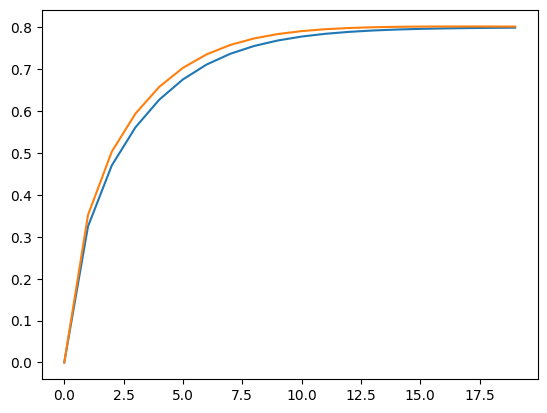

In [191]:
plt.plot(P_ytrack[800,:])
plt.plot(P_ytrack[801,:])